In [63]:
import base64
from openai import OpenAI
import os

In [22]:
! pip install langchain_openai

  Attempting uninstall: openai
    Found existing installation: openai 1.52.0
    Uninstalling openai-1.52.0:
      Successfully uninstalled openai-1.52.0


In [64]:
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")

In [65]:
def classify_document(image_path: str) -> str:
    # Getting the base64 string
    base64_image = encode_image(image_path)

    client = OpenAI()
    
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {
                "role": "user",
                "content": [
                    {
                        "type": "text",
                        "text": "Is this document personal or financial? Only reply personal or financial no other words.",
                    },
                    {
                        "type": "image_url",
                        "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"},
                    },
                ],
            }
        ],
    )

    content = response.choices[0].message.content
    return content

In [66]:
from langchain.agents import tool

@tool
def document_identifier_tool(image_path: str) -> str:
    """Identifies whether the document in the image is personal or financial."""
    return classify_document(image_path)

In [67]:
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent

llm = ChatOpenAI(model="gpt-4o")

document_identifier_agent = create_react_agent(
    llm,
    tools=[document_identifier_tool]
)


In [68]:
from typing import List, Optional, Literal, TypedDict
from langchain_core.language_models.chat_models import BaseChatModel

from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.types import Command
from langchain_core.messages import HumanMessage, trim_messages


def make_supervisor_node(llm: BaseChatModel, members: List[str]) -> str:
    options = ["FINISH"] + members
    system_prompt = (
        "You are a supervisor tasked with classifying documents"
        f" following workers: {members}. Given the following user request,"
        " respond with the worker to act next. Each worker will perform a"
        " task and respond with their results and status. When finished,"
        " respond with FINISH."
    )

    # Dynamically create a Literal type with the valid options
    RouterLiteral = Literal[tuple(options)]

    class Router(TypedDict):
        """Worker to route to next. If no workers needed, route to FINISH."""
        next: RouterLiteral

    def supervisor_node(state: MessagesState) -> Command[Literal[tuple(members + ["__end__"])]]:
        """An LLM-based router."""
        messages = [
            {"role": "system", "content": system_prompt},
        ] + state["messages"]
        print(system_prompt)
        response = llm.with_structured_output(Router).invoke(messages)
        print(response)
        goto = response["next"]
        if goto == "FINISH":
            goto = END

        return Command(goto=goto)

    return supervisor_node


In [69]:
def doc_identifier_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    result = document_identifier_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="doc_classifier")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )

In [70]:
classifier_supervisor_node = make_supervisor_node(llm, ["doc_classifier"])

In [71]:
research_builder = StateGraph(MessagesState)
research_builder.add_node("supervisor", classifier_supervisor_node)
research_builder.add_node("doc_classifier", doc_identifier_node)
#research_builder.add_node("web_scraper", web_scraper_node)

research_builder.add_edge(START, "supervisor")
research_graph = research_builder.compile()

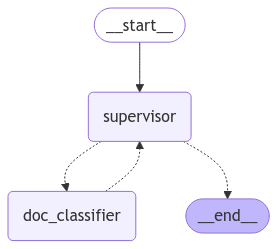

In [72]:
from IPython.display import Image, display

display(Image(research_graph.get_graph().draw_mermaid_png()))

In [73]:
for s in research_graph.stream(
    {"messages": [("user", "fin1.png")]}, subgraphs=True
):
    print(s)
    print("----")

You are a supervisor tasked with classifying documents following workers: ['doc_classifier']. Given the following user request, respond with the worker to act next. Each worker will perform a task and respond with their results and status. When finished, respond with FINISH.
{'next': 'doc_classifier'}
((), {'supervisor': None})
----
(('doc_classifier:5bbdef80-c3bd-e68e-e522-49892f2166c0',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_aXceoHy6jnsaHzrzAi06EjOd', 'function': {'arguments': '{"image_path":"fin1.png"}', 'name': 'document_identifier_tool'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 55, 'total_tokens': 74, 'completion_tokens_details': {'audio_tokens': 0, 'reasoning_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fing